In [1]:
import tensorflow as tf
import os
import time
import numpy as np
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Input, LeakyReLU, InputLayer, Flatten
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import re
from time import time

In [ ]:
for i in range(1,3):
    img = cv2.imread('\{}.png'.format(i),-1)
    rgbimg = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    
    cv2.imwrite('\{}.png'.format(i), rgbimg)

In [2]:
EPOCHS = 150
BUFFER_SIZE = 575
BATCH_SIZE = 50
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [3]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [4]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [5]:
test_dataset = tf.data.Dataset.list_files('\*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [6]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [8]:
from keras.models import load_model
model = load_model('AnimeColorizationModelv7.h5', compile=False)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

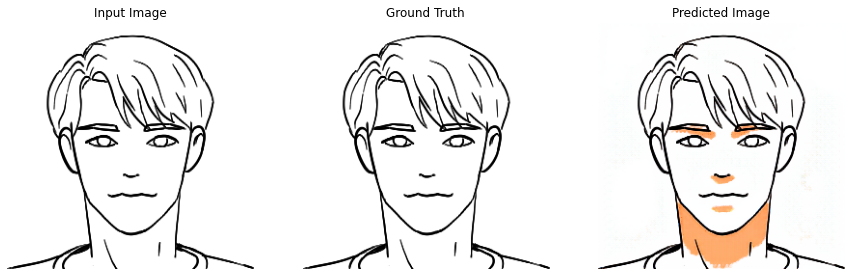

그림자 생성 시간: 0.33초


In [15]:
begin = time()

for example_input, example_target in test_dataset.take(1):
    generate_images(model, example_input, example_target)
    
end = time()

print('그림자 생성 시간: {:.2f}초'.format(end-begin))